In [1]:
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (150, 150, 3))

In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
from keras.utils.vis_utils import plot_model
plot_model(conv_base, to_file='VGG16_plot.png', show_shapes=True, show_layer_names=True)

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/g0d/dev/data/DL2018/cats_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150, 150),
        batch_size = batch_size,
        class_mode = 'binary')
    
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size:(i+1) * batch_size] = features_batch
        labels[i * batch_size:(i+1) * batch_size] = labels_batch
        i+=1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)


        


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
# DENSE CLASSIFIER ACCEPTS FLAT INPUT

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))



In [8]:
from keras import models, layers, optimizers

model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [9]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [10]:
import time

start_time = time.time()

history = model.fit(train_features, train_labels,
                   epochs = 30,
                   batch_size = 20,
                   validation_data=(validation_features, validation_labels))

print("--- Total %s seconds ---" % (time.time() - start_time))



Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 868us/step - loss: 0.6138 - acc: 0.6600 - val_loss: 0.4573 - val_acc: 0.8230
Epoch 2/30
2000/2000 [==============================] - 1s 742us/step - loss: 0.4317 - acc: 0.8085 - val_loss: 0.3696 - val_acc: 0.8690
Epoch 3/30
2000/2000 [==============================] - 1s 735us/step - loss: 0.3490 - acc: 0.8550 - val_loss: 0.3285 - val_acc: 0.8730
Epoch 4/30
2000/2000 [==============================] - 1s 735us/step - loss: 0.3229 - acc: 0.8700 - val_loss: 0.3004 - val_acc: 0.8890
Epoch 5/30
2000/2000 [==============================] - 1s 735us/step - loss: 0.2912 - acc: 0.8810 - val_loss: 0.2854 - val_acc: 0.8980
Epoch 6/30
2000/2000 [==============================] - 1s 735us/step - loss: 0.2645 - acc: 0.9000 - val_loss: 0.2740 - val_acc: 0.9030
Epoch 7/30
2000/2000 [==============================] - 1s 733us/step - loss: 0.2419 - acc: 0.9050 - val_loss: 0.2903 - val_acc: 0.8740


In [ ]:
# 0.9 vs 0.8 acc in much less time!

In [11]:
hist = history.history
acc = hist['acc']
val_acc = hist['val_acc']
loss = hist['loss']
val_loss = hist['val_loss']
epochs = range(1, len(acc)+1)

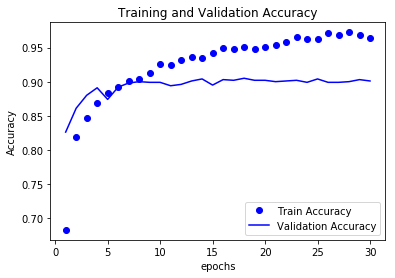

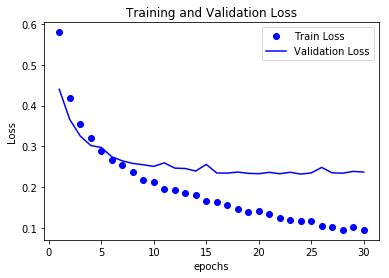

In [11]:
import matplotlib.pyplot as plt

plt.plot(epochs, acc, 'bo', label='Train Accuracy' )
plt.plot(epochs, val_acc,'b', label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train Loss')
plt.plot(epochs, val_loss,'b',  label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()